# MNIST

In [45]:
import numpy as np
import custom_impl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from custom_impl import MaxPool2d, ReLU, Conv2d
from torch import nn
import torch

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

# sources 
# https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

# data
# https://github.com/zalandoresearch/fashion-mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

X_train = X_train.reshape(-1,1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    def __init__(self, samples, labels, batch_size):
        self.samples = torch.tensor(samples, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)
        self.batch_size = batch_size
        self.num_samples = len(samples)
        self.num_batches = ((self.num_samples + batch_size -1) // self.batch_size)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_samples = self.samples[start_idx:end_idx]
        batch_labels = self.labels[start_idx:end_idx]
        return batch_samples, batch_labels

    def __len__(self):
        return self.num_batches

    def shuffle(self):
        shuffled_indices = torch.randperm(self.num_samples)
        self.samples = self.samples[shuffled_indices]
        self.labels = self.labels[shuffled_indices]

    def __iter__(self):
        self.current_batch = 0
        return self

    def __next__(self):
        if self.current_batch < self.num_batches:
            batch_samples, batch_labels = self[self.current_batch]
            self.current_batch += 1
            return batch_samples, batch_labels
        else:
            raise StopIteration


train_dataset = Dataset(X_train, y_train, 256)
test_dataset = Dataset(X_test, y_test, 128)

## normalize data

In [4]:
data_mean = np.mean(X_train)
data_stdev = np.std(X_train)

def normalize(data: np.ndarray):
  return (data - data_mean) / data_stdev

## Visualize classes

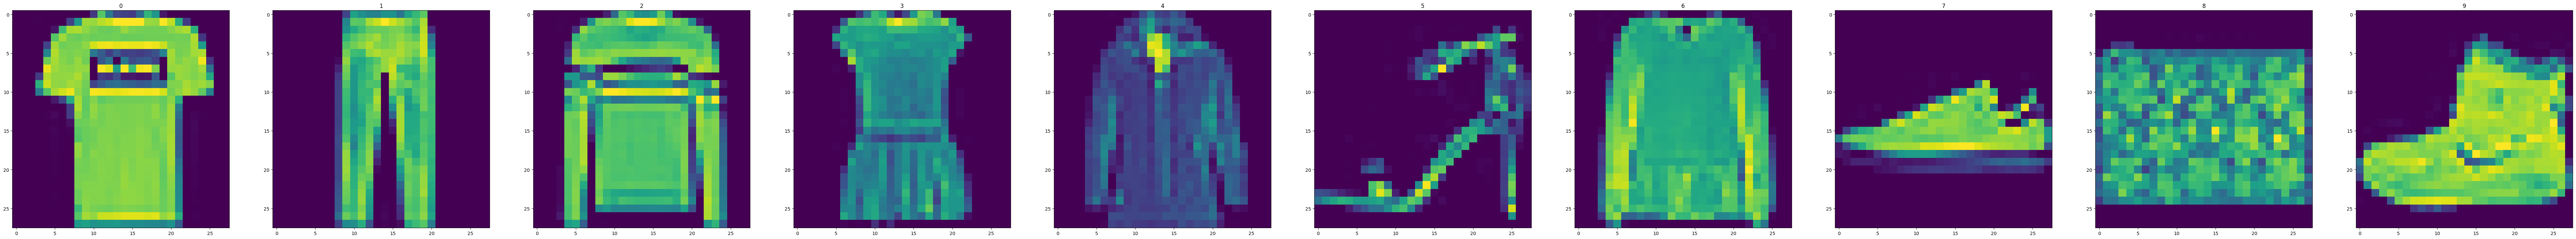

In [5]:
uniq_classes = np.unique(y_train)
fig, axs = plt.subplots(1, len(uniq_classes), figsize=(100,10))

output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

for i, clas in enumerate(uniq_classes):
  index = np.argwhere(y_train == clas)[0]
  img = X_train[index][0].transpose(1,2,0)
  axs[i].set_title(clas)
  axs[i].imshow(img)

## Model

In [6]:
x, y = train_dataset[0]
f=ReLU()
result=f(x)

In [32]:

class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1),
            nn.BatchNorm2d(64),
            ReLU(),
            MaxPool2d(2,1)
        )
        
        self.drop = nn.Dropout(0.1)
        self.fc1 = nn.Linear(in_features=6400, out_features=600)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [40]:
model = FashionCNN().to(device)

error = nn.CrossEntropyLoss().to(device)

learning_rate = 0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d()
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d()
  )
  (layer2): Sequential(
    (0): Conv2d()
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d()
  )
  (drop): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6400, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [41]:

num_epochs = 25
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in tqdm(train_dataset, desc=f"epoch {epoch}"):
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = torch.autograd.Variable(images.view(-1, 1, 28, 28))
        labels = torch.autograd.Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        count += 1
    
    # Testing the model
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_dataset:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = torch.autograd.Variable(images.view(-1, 1, 28, 28))
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 300):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

epoch 1:  33%|███▎      | 77/235 [00:01<00:03, 48.98it/s]

Iteration: 300, Loss: 0.42098066210746765, Accuracy: 85.93999481201172%


epoch 2:  60%|█████▉    | 140/235 [00:02<00:01, 49.35it/s]

Iteration: 600, Loss: 0.3051659166812897, Accuracy: 87.16999816894531%


epoch 3:  87%|████████▋ | 205/235 [00:03<00:00, 49.82it/s]

Iteration: 900, Loss: 0.34067484736442566, Accuracy: 88.06999969482422%


epoch 5:  15%|█▍        | 35/235 [00:00<00:04, 44.85it/s]

Iteration: 1200, Loss: 0.29830074310302734, Accuracy: 88.0%


epoch 6:  45%|████▍     | 105/235 [00:01<00:02, 47.58it/s]

Iteration: 1500, Loss: 0.25239062309265137, Accuracy: 88.22000122070312%


epoch 7:  71%|███████   | 166/235 [00:03<00:01, 46.60it/s]

Iteration: 1800, Loss: 0.2799985706806183, Accuracy: 88.95999908447266%


epoch 8: 100%|██████████| 235/235 [00:04<00:00, 52.14it/s]


Iteration: 2100, Loss: 0.24502353370189667, Accuracy: 88.98999786376953%


epoch 10:  25%|██▌       | 59/235 [00:01<00:03, 47.26it/s]

Iteration: 2400, Loss: 0.24524521827697754, Accuracy: 88.97000122070312%


epoch 11:  55%|█████▌    | 130/235 [00:02<00:02, 46.20it/s]

Iteration: 2700, Loss: 0.2114066481590271, Accuracy: 88.94999694824219%


epoch 12:  83%|████████▎ | 195/235 [00:03<00:00, 46.80it/s]

Iteration: 3000, Loss: 0.17537228763103485, Accuracy: 88.83999633789062%


epoch 14:  10%|█         | 24/235 [00:00<00:05, 40.49it/s]

Iteration: 3300, Loss: 0.26075780391693115, Accuracy: 88.20999908447266%


epoch 15:  37%|███▋      | 88/235 [00:01<00:03, 45.86it/s]

Iteration: 3600, Loss: 0.2046354115009308, Accuracy: 89.5999984741211%


epoch 16:  65%|██████▌   | 153/235 [00:02<00:01, 45.83it/s]

Iteration: 3900, Loss: 0.2170036882162094, Accuracy: 88.7699966430664%


epoch 17:  91%|█████████▏| 215/235 [00:04<00:00, 47.41it/s]

Iteration: 4200, Loss: 0.2502994239330292, Accuracy: 90.0%


epoch 19:  21%|██        | 49/235 [00:00<00:04, 45.82it/s]

Iteration: 4500, Loss: 0.21435900032520294, Accuracy: 89.08999633789062%


epoch 20:  49%|████▉     | 115/235 [00:02<00:02, 46.51it/s]

Iteration: 4800, Loss: 0.16814611852169037, Accuracy: 89.43000030517578%


epoch 21:  75%|███████▍  | 176/235 [00:03<00:01, 45.54it/s]

Iteration: 5100, Loss: 0.24040187895298004, Accuracy: 88.94999694824219%


epoch 22: 100%|██████████| 235/235 [00:04<00:00, 51.86it/s]


Iteration: 5400, Loss: 0.14184747636318207, Accuracy: 88.4000015258789%


epoch 24:  31%|███       | 72/235 [00:01<00:03, 44.19it/s]

Iteration: 5700, Loss: 0.14341303706169128, Accuracy: 88.83999633789062%


epoch 24: 100%|██████████| 235/235 [00:04<00:00, 50.69it/s]


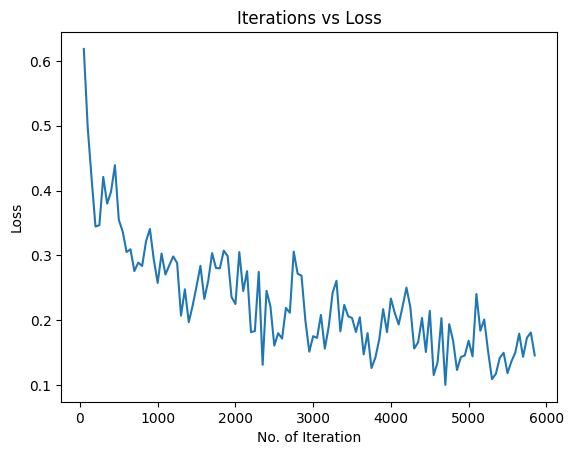

In [42]:
plt.plot([i for i in iteration_list], [i.cpu() for i in loss_list])
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

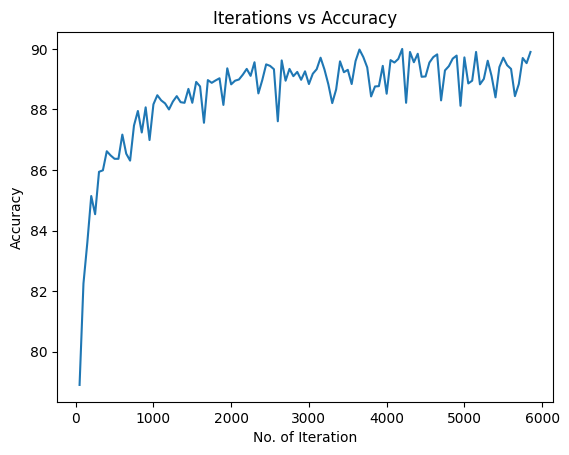

In [43]:
plt.plot(iteration_list, [i.cpu() for i in accuracy_list])
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [44]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

with torch.no_grad():
    for images, labels in test_dataset:
        images, labels = images.to(device), labels.to(device)
        test = torch.autograd.Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 93.55%
Accuracy of Trouser: 96.09%
Accuracy of Pullover: 86.49%
Accuracy of Dress: 90.23%
Accuracy of Coat: 79.72%
Accuracy of Sandal: 99.20%
Accuracy of Shirt: 52.59%
Accuracy of Sneaker: 86.96%
Accuracy of Bag: 92.74%
Accuracy of Ankle Boot: 97.62%


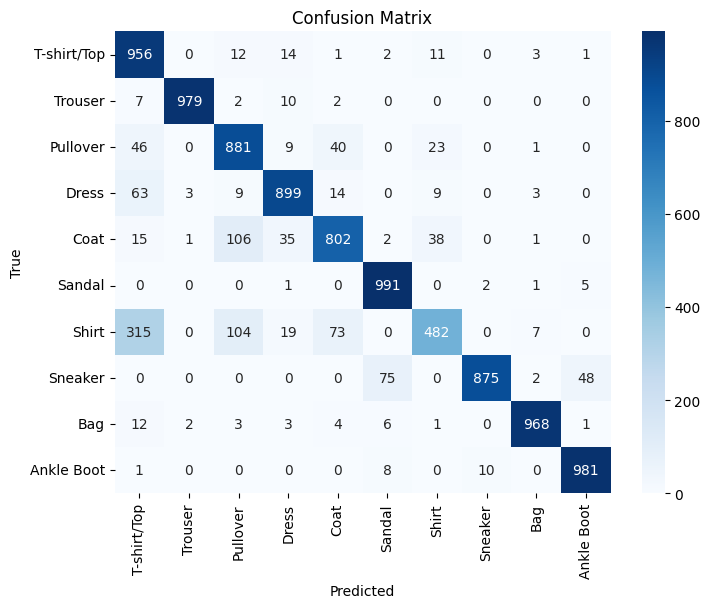

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_dataset:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
class_labels = [output_label(i) for i in np.arange(10)]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()